In [1]:
from yahoo_fin import stock_info as si
import yfinance as yf
import pandas as pd
import quandl
import numpy as np
import numpy.random as npr
import math
from scipy.stats import norm
from pandas.tseries.offsets import BDay
from datetime import datetime

# Distribution functions
from scipy.stats import norm

# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get data
tesla = yf.Ticker("TSLA")
expiration_dates = list(tesla.options)


In [3]:
# Work out dates
today = datetime.today().strftime('%Y-%m-%d')

call_files = list()
for d in expiration_dates:
    call_files.append(tesla.option_chain(d).calls)

bday_diffs = list()
for ed in expiration_dates:
    bday_diffs.append(float(np.busday_count(today, ed)))

T = [x / 252 for x in bday_diffs]
call_option_dictionary = dict(zip(T, call_files))

post_dated_dataframes = list()
for k, v in call_option_dictionary.items():
    v["Time"] = k
    post_dated_dataframes.append(v)

In [4]:
# Data manipulation
df = pd.concat(post_dated_dataframes)
df = df.loc[df["inTheMoney"] == True]
df["Time"] = df["Time"].replace(0, 0.00000001)
df["impliedVolatility"] = df['impliedVolatility'].replace(0, 0.0001)
df = df[["strike", "impliedVolatility", "Time"]]
df = df[(df[["Time"]] > 0).all(1)]

df = df.rename(columns={
    "impliedVolatility":"Vol",
    "strike":"K"
})

# Add columns
df["S0"] = si.get_live_price("tsla")
r = quandl.get(["USTREASURY/YIELD.10"], rows=1)
r = r.iloc[0, 0]
df["r"] = r 
df['Moneyness'] = df['K'] / df['S0']

In [5]:
# Calculate call option price
df["d1"] = ((np.log(df["S0"] / df["K"]) + (df["r"] + 0.5 * (df["Vol"] ** 2)) * df["Time"]) / (df["Vol"] * np.sqrt(df["Time"])))
df["d2"] = df["d1"] - (df["Vol"] * np.sqrt(df["Time"]))
df["Price"] = df["S0"] * norm.cdf(df["d1"]) - df["K"] * np.exp(-df["r"] * df["Time"]) * norm.cdf(df["d2"])

In [6]:
# Filter for Visualisation
dataset = df[[
    "Price",
    "Moneyness",
    "Time",
    "Vol"
]]
dataset.head()

Price  Moneyness      Time      Vol
0  433.012461   0.002304  0.015873  0.00010
1  432.024923   0.004608  0.015873  0.00010
2  431.037384   0.006912  0.015873  0.00010
3  430.049846   0.009217  0.015873  0.00010
4  429.062307   0.011521  0.015873  0.00001

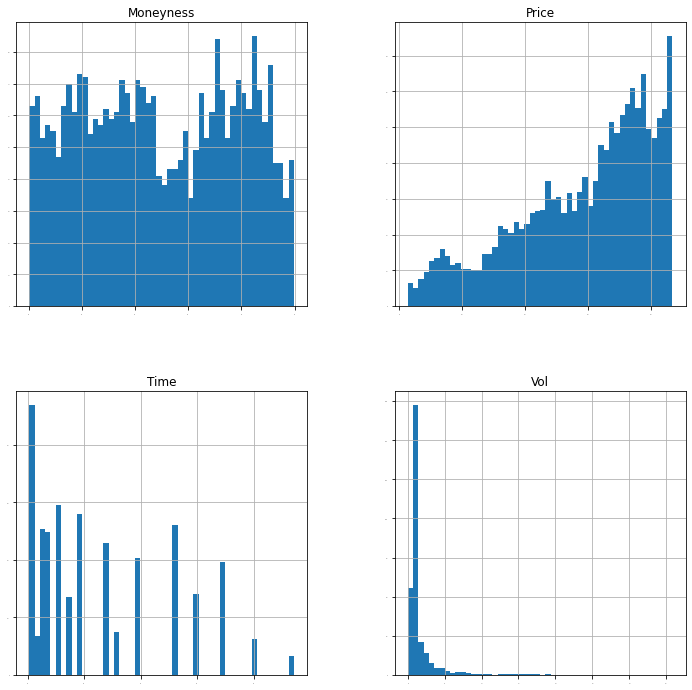

In [7]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

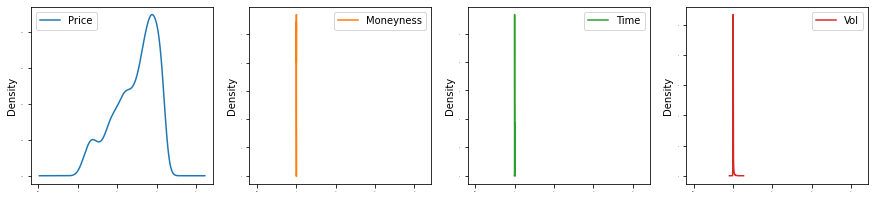

In [8]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

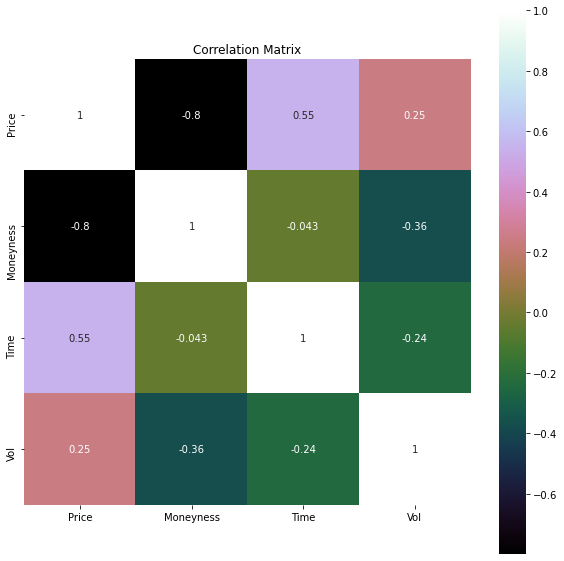

In [9]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

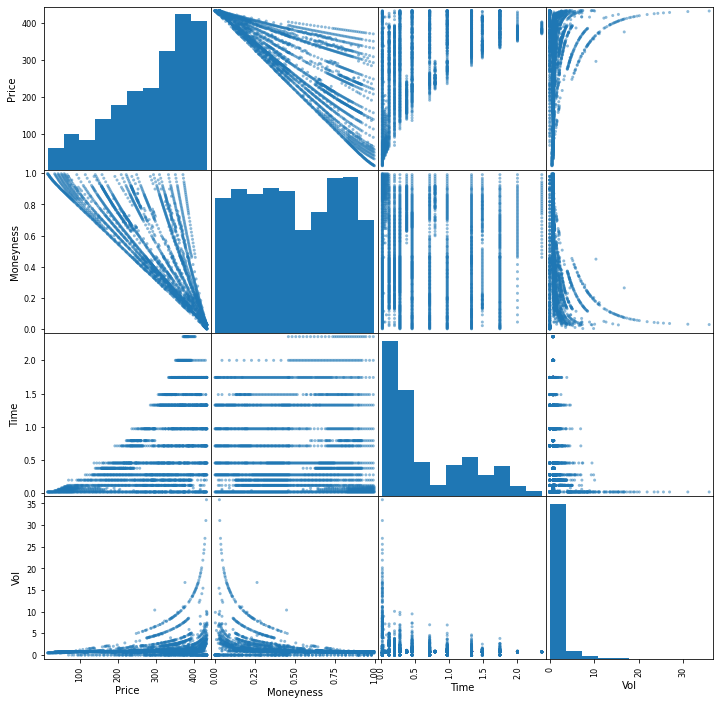

In [10]:
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

In [11]:
dataset.to_csv("data/dataset.csv", index=False)